# Outlier Removal

## Setup

In [9]:
import pandas as pd

## 1. Outlier Removal Operations
- Outliers are unusual values in your dataset, and they can distort statistical analyses. 

### 1.1 `clip`
- If you want to trim values that the outliers, one of the methods are to use `df.clip`

In [10]:
data = {'A': [9, -3, 0, -1, 5]}
df = pd.DataFrame(data)
df.head()

,A
0,9
1,-3
2,0
3,-1
4,5


- Example: to exclude the outliers that are below `.05` percentile or above `.95` percentile

In [11]:
lower_bound, upper_bound = df['A'].quantile(.05), df['A'].quantile(.95)
print(lower_bound, upper_bound)

-2.6 8.2


In [12]:
df.loc[: ,'A'] = df['A'].clip(lower=lower_bound, upper=upper_bound)

In [13]:
# As you can see, -3 becomes -2, and 9 becomes 8
df.head()

,A
0,8.2
1,-2.6
2,0.0
3,-1.0
4,5.0


### 1.2. `isin` Filter Rows only if Column Contains Values from a List

In [14]:
df = pd.DataFrame({'col1': [1, 2, 3, 4, 5], 'col2': ['a', 'b', 'c', 'd', 'e']})
df.head()

,col1,col2
0,1,a
1,2,b
2,3,c
3,4,d
4,5,e


- Example, in `col2`, we only want to keep the rows whose values are `NOT 'a', 'b', 'c'`

In [15]:
excluded_list = ['a', 'b', 'c']
df = df.loc[~df['col2'].isin(excluded_list), :]

In [16]:
df.head()

,col1,col2
3,4,d
4,5,e


## 2. Create Outlier Removal as Custom Transformers

In [53]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.compose import ColumnTransformer
import numpy as np

from sklearn import datasets

iris = datasets.load_iris()
iris_df = pd.DataFrame(iris['data'], columns=iris['feature_names'])
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [50]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        return X
    
outlier_remover = OutlierRemover()

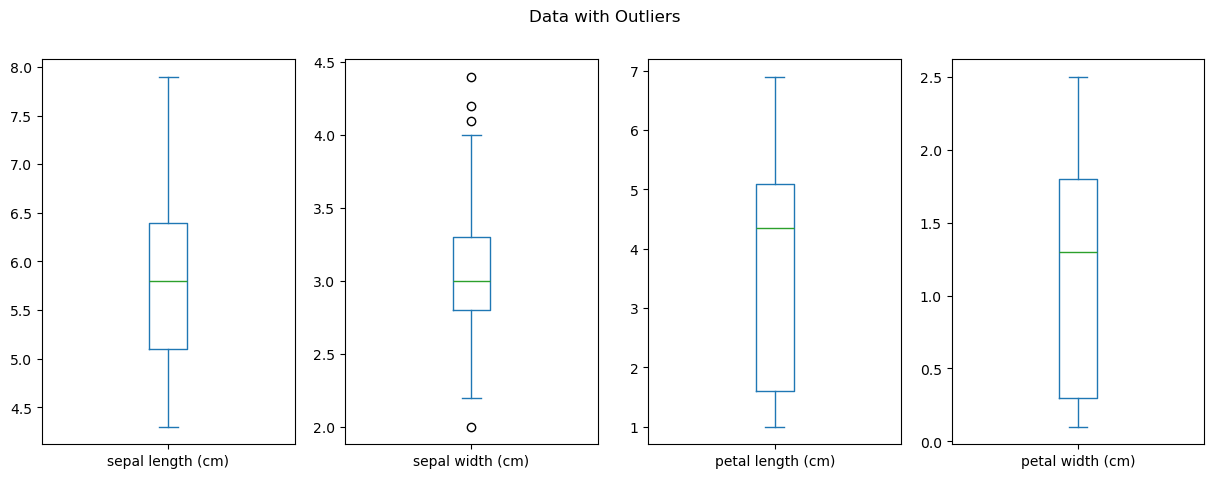

In [52]:
iris_df.plot(kind="box",subplots=True,figsize=(15,5),title="Data with Outliers");

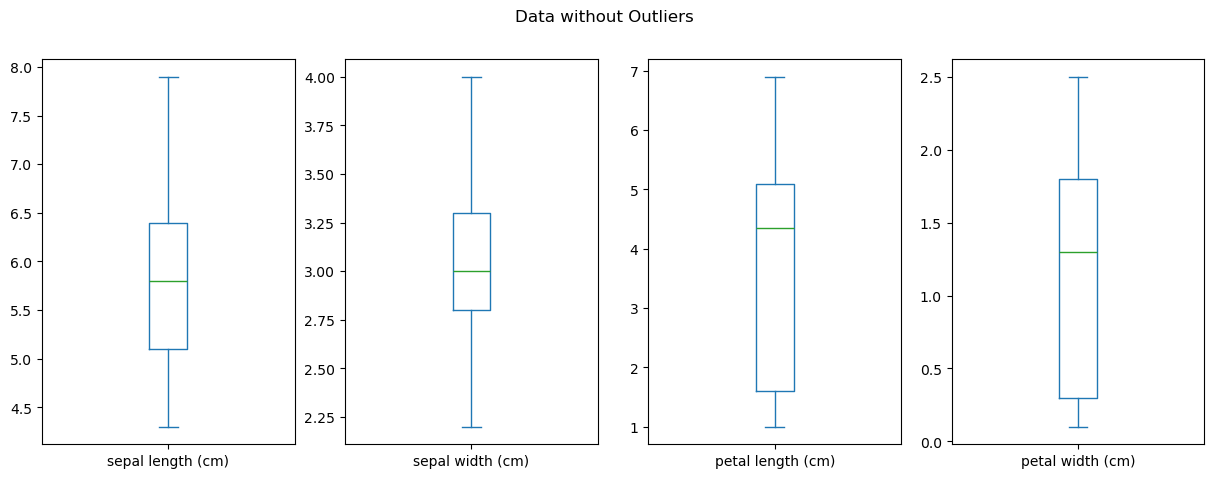

In [58]:
outlier_remover = OutlierRemover()

#ColumnTransformer to remove outliers
ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(), iris_df.columns]],remainder='passthrough')

#iris data after outlier removal
data_without_outliers = pd.DataFrame(ct.fit_transform(iris_df),columns=iris_df.columns)

#iris data box plot after outlier removal
data_without_outliers.plot(kind="box",subplots=True,figsize=(15,5),title="Data without Outliers");


In [59]:
# 4 outliers are removed from SepalWidthCm, other columns stayed the same as they have no outliers.
data_without_outliers.isnull().sum()

sepal length (cm)    0
sepal width (cm)     4
petal length (cm)    0
petal width (cm)     0
dtype: int64